In [1]:
seed=1226

In [2]:
import warnings
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
import tensorflow as tf


tf.random.set_seed(seed)

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense,Input,Reshape, Flatten,ELU,RepeatVector,TimeDistributed, Bidirectional, PReLU, Concatenate, Subtract
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
import glob
import keras
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
# from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# from sklearn.metrics import r2_score
from keras.utils import plot_model
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
np.random.seed(seed)
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from keras.utils import to_categorical
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
# import seaborn as sns
rcParams['figure.figsize']=15,5

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [4]:
from time import time


import pandas as pd
import random

# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,7)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
Stations = ['Batseri kinnaur','Gharpa','ghoda_farm3_mandi','griffon peak 2','griffon_peak3',
            'kuppa_data','nigulasridata','pagalnala_data','purbani_kinnaur','sanarli_1_mandi','sanarli_3_mandi',
            'sandhol kangra','urni_dhank_kinnaur','griffon peak5 mandi']

In [7]:
Column = ['Date','Tem','Hum','Pressure','Rain','Light','Ax','Ay','Az','Wx','Wy','Wz','Moisture','Count']

In [8]:
lag=10

In [9]:
#Rearrange the Array
def makeArray(Array):
    New=np.array(Array[0])

    for i in range(1,len(Array)):
        New = np.append(New,Array[i],axis=0)
        
    return New

In [10]:
def readData(Stations):
    
    Data, C = [], []
    
#     print(Stations)
    file = Stations+'.csv'
    newfile = 'clean_'+file
    df = pd.read_csv('Clean-dataset-LMS/'+newfile, header=0, index_col=None)
    print(newfile)
    df = df.reset_index(drop=True)
    data=df[['Tem','Hum','Pressure','Rain','Light','Ax','Ay','Az','Wx','Wy','Wz','Moisture','Count']].values
    data=data.astype('float32')
    count=df['Count'].values
    count=count.astype('float32')

    #Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    Data.append(data)
    C.append(count)
           
    
        
    return makeArray(Data), makeArray(C)


In [11]:
Data=[[] for x in range(len(Stations))]
Count=[[] for x in range(len(Stations))]
for i in range(len(Stations)):
    Data[i], Count[i] = readData(Stations[i])

clean_Batseri kinnaur.csv
clean_Gharpa.csv
clean_ghoda_farm3_mandi.csv
clean_griffon peak 2.csv
clean_griffon_peak3.csv
clean_kuppa_data.csv
clean_nigulasridata.csv
clean_pagalnala_data.csv
clean_purbani_kinnaur.csv
clean_sanarli_1_mandi.csv
clean_sanarli_3_mandi.csv
clean_sandhol kangra.csv
clean_urni_dhank_kinnaur.csv
clean_griffon peak5 mandi.csv


In [12]:
def getData(data, C, lag,z):
    DataX, DataY = [], []
    count=0
    for i in range(lag,len(data)):
        if C[i]>0:
            count+=1
            DataX.append(data[i-lag:i,:])
            
    
    countnew=0
    idx=lag
    np.random.seed(z)
    per = np.random.permutation(len(data))
    for i in per:

        if C[i]==0:
            if sum(C[lag-i:i])==0:
                countnew+=1
                DataY.append(data[i-lag:i,:])
                
        if countnew==count:
            break
    DataX=np.array(DataX).astype(np.float32)   
    DataY=np.array(DataY).astype(np.float32)
    print(DataX.shape,DataY.shape)
    return DataX, DataY
    

In [13]:
def makeData(Data,Count,lag):
    
    #Make the packets by lag value
    f = True
    g=0
    h=0
    y=0
    l=len(Count)
    R=[1998,7161,8200,1461,7168,5312,2202,8668,9335,6188,6934,6314,4156,5377]
    while(f and g<l):
        try:
            DataX, DataY = getData(Data, Count, lag, R[h])
            f=False
        except:
            g+=1
            h+=1
            h%=14
            x=int(g/l*100)
            if x-y!=0:
                print(str(x)+', ',end='')
            y=x

#     print(len(DataX),len(DataY))
    
    np.random.seed(seed)
    per = np.random.permutation(len(DataX))
    Mov = DataX[:]
    NonMov = DataY[:]
    
    
    #Creating labels
    A=np.ones(len(Mov))
    B=np.zeros(len(NonMov))
    
       

    #Creating One-Hot-Encoding
    C=np.hstack((A,B))
    D=to_categorical(C, dtype ="uint8")
    E=D[:len(Mov)]
    F=D[len(Mov):]

    
    
        
    return (Mov, E), (NonMov, F)



In [14]:
def comp(Train):
    T=[]
    for x in Train:
        for y in x:
            T.append(y)
    return np.array(T)

In [15]:
def anotherLevel(encoded_Data,Count,lag):
    Mov=[]
    Mov_L=[]
    NoMov= []
    NoMov_L= []

    for i in range(len(Stations)):
        if sum(Count[i][lag:])>0:
            (A, B),(C, D) = makeData(encoded_Data[i], Count[i],lag)
            Mov.append(A)
            NoMov.append(C)
            Mov_L.append(B)
            NoMov_L.append(D)

    total = len(Mov)

    Train =[]
    Test =[]
    TrainL =[]
    TestL =[]
    Movement=[]
    NoMovement=[]
    MovementL=[]
    NoMovementL=[]

    for i in range(total):

        MM = Mov[i][:]
        NN = NoMov[i][:]
        OO = Mov_L[i][:]
        PP = NoMov_L[i][:]
        Movement.append(MM)
        NoMovement.append(NN)
        MovementL.append(OO)
        NoMovementL.append(PP)

    
    Movement=comp(Movement) 
    NoMovement=comp(NoMovement)
    MovementL=comp(MovementL)
    NoMovementL=comp(NoMovementL)
    
    t=int(len(Movement)*0.2)
    np.random.seed(seed)
    per=np.random.permutation(len(Movement))
    per=per[:t]
    for i in range(len(Movement)):
        if i in per:
            Test.append(Movement[i])
            Test.append(NoMovement[i])
            TestL.append(MovementL[i])
            TestL.append(NoMovementL[i])
        else:
            Train.append(Movement[i])
            Train.append(NoMovement[i])
            TrainL.append(MovementL[i])
            TrainL.append(NoMovementL[i])
    
    Train=np.array(Train)
    TrainL=np.array(TrainL)
    Test=np.array(Test)
    TestL=np.array(TestL)
    return (Train,TrainL),(Test,TestL)

        

In [16]:
class NoiseLayer(tf.keras.layers.Layer):
    def __init__(self, p):
        super(NoiseLayer, self).__init__()
        self.p = p
        
        
    def call(self, inputs,training=False):

        if training:
                    

            Gaussioan_noise = tf.random.normal( shape=tf.shape(inputs), mean=0, stddev=0.01, dtype=inputs.dtype)
            Gaussioan_noise=tf.nn.dropout(Gaussioan_noise,1-self.p)

            inputs = inputs+Gaussioan_noise

            inputs=inputs/tf.reduce_max(inputs,axis=1, keepdims=True)

        return inputs

In [17]:
def tSNE(Train,TrainL,Test,TestL):
    
    x_subset = Train[:]
    y_subset = [np.argmax(x) for x in TrainL[:]]

    x_subset1 = Test[:]
    y_subset1 = [np.argmax(x) for x in TestL[:]]

    print(np.unique(y_subset))
    x_subset=x_subset.reshape((x_subset.shape[0],x_subset.shape[1]*x_subset.shape[2]))
    x_subset1=x_subset1.reshape((x_subset1.shape[0],x_subset1.shape[1]*x_subset1.shape[2]))
    %time
    tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset)
    tsne2 = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset1)
    plt.scatter(tsne[:, 0], tsne[:, 1], s= 50, c=y_subset, cmap='Spectral',edgecolors='black')
    plt.scatter(tsne2[:, 0], tsne2[:, 1], s= 50, c=y_subset1, cmap='spring',edgecolors='black')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(2)-0.5).set_ticks(np.arange(2))
    plt.title('Visualizing through t-SNE', fontsize=24);

def tSNE2(Train,TrainL,Test,TestL):
    
    x_subset = Train[:]
    y_subset = [np.argmax(x) for x in TrainL[:]]

    x_subset1 = Test[:]
    y_subset1 = [np.argmax(x) for x in TestL[:]]

    print(np.unique(y_subset))
    x_subset=x_subset.reshape((x_subset.shape[0],x_subset.shape[1]))
    x_subset1=x_subset1.reshape((x_subset1.shape[0],x_subset1.shape[1]))
    %time
    tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset)
    tsne2 = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset1)
    plt.scatter(tsne[:, 0], tsne[:, 1], s= 50, c=y_subset, cmap='Spectral',edgecolors='black')
    plt.scatter(tsne2[:, 0], tsne2[:, 1], s= 50, c=y_subset1, cmap='spring',edgecolors='black')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(2)-0.5).set_ticks(np.arange(2))
    plt.title('Visualizing through t-SNE', fontsize=24);

In [18]:
def matrix(Train,TrainL,Test, TestL,TrainOne,TrainOneL,TestOne, TestOneL):
    f, axes = plt.subplots(1, 4, figsize=(15, 5), sharey='row')
    Predict=[]
    True_cls=[]
    test=Train
    y=TrainL

    P=model.predict(test,verbose=0)
    Predict=np.argmax(P,axis=1)
    True_cls=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls, Predict, labels=[0,1])
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp1.plot(ax=axes[0])
    disp1.im_.colorbar.remove()

    Predict2=[]
    True_cls2=[]
    test=Test
    y=TestL
    P=model.predict(test,verbose=0)
    Predict2=np.argmax(P,axis=1)
    True_cls2=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls2, Predict2, labels=[0,1])
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp2.plot(ax=axes[1])
    disp2.im_.colorbar.remove()

    test=TrainOne
    y=TrainOneL

    P=model2.predict(test,verbose=0)
    Predict3=np.argmax(P,axis=1)
    True_cls3=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls3, Predict3, labels=[0,1])
    disp3 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp3.plot(ax=axes[2])
    disp3.im_.colorbar.remove()


    test=TestOne
    y=TestOneL
    P=model2.predict(test,verbose=0)
    Predict4=np.argmax(P,axis=1)
    True_cls4=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls4, Predict4, labels=[0,1])
    disp4 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp4.plot(ax=axes[3])
    disp4.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    plt.show()

def matrix1(model, Train,TrainL,Test, TestL):
    f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')
    Predict=[]
    True_cls=[]
    test=Train
    y=TrainL

    P=model.predict(test,verbose=0)
    Predict=np.argmax(P,axis=1)
    True_cls=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls, Predict, labels=[0,1])
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp1.plot(ax=axes[0])
    disp1.im_.colorbar.remove()

    Predict2=[]
    True_cls2=[]
    test=Test
    y=TestL
    P=model.predict(test,verbose=0)
    Predict2=np.argmax(P,axis=1)
    True_cls2=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls2, Predict2, labels=[0,1])
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp2.plot(ax=axes[1])
    disp2.im_.colorbar.remove()

    
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    plt.show()

In [19]:
(Train,TrainL),(Test,TestL) = anotherLevel(Data,Count,lag)

(3, 10, 13) (3, 10, 13)
(1, 10, 13) (1, 10, 13)
(475, 10, 13) (475, 10, 13)
(464, 10, 13) (464, 10, 13)
(10, 10, 13) (10, 10, 13)
(2, 10, 13) (2, 10, 13)
(2, 10, 13) (2, 10, 13)
(1, 10, 13) (1, 10, 13)
(3, 10, 13) (3, 10, 13)


In [20]:
ft=Data[0].shape[1]

TrainX = Train.reshape((-1,ft))
TestX = Test.reshape((-1,ft))
TrainX.shape,TestX.shape

((15380, 13), (3840, 13))

In [21]:
maxvalue=max(np.max(TrainX),np.max(TestX))
minvalue=min(np.min(TrainX),np.min(TestX))
TrainX = (TrainX-minvalue)/(maxvalue-minvalue)
TestX = (TestX-minvalue)/(maxvalue-minvalue)
maxvalue,minvalue

(1.0, 0.0)

In [22]:
(TrainOne,TrainOneL),(TestOne,TestOneL) = anotherLevel(Data,Count,lag)

(3, 10, 13) (3, 10, 13)
(1, 10, 13) (1, 10, 13)
(475, 10, 13) (475, 10, 13)
(464, 10, 13) (464, 10, 13)
(10, 10, 13) (10, 10, 13)
(2, 10, 13) (2, 10, 13)
(2, 10, 13) (2, 10, 13)
(1, 10, 13) (1, 10, 13)
(3, 10, 13) (3, 10, 13)


In [23]:


reset_random_seeds(seed)
# define encoder
visible = Input(shape=(10,13,))
encoder = Bidirectional(LSTM(50, activation='relu'))(visible)

# define reconstruct decoder
decoder1 = RepeatVector(10)(encoder)
decoder1 = Bidirectional(LSTM(50, activation='relu', return_sequences=True))(decoder1)
decoder1 = TimeDistributed(Dense(13),name='out1')(decoder1)


# define predict decoder
decoder2 = RepeatVector(1)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=False)(decoder2)
# decoder2 = TimeDistributed(Dense(100))(decoder2)
# decoder2 = Flatten()(decoder2)
decoder2 = Dense(13,activation='relu')(decoder2)
decoder2 = Dense(2,activation='softmax',name='out2')(decoder2)

# tie it together
final = Model(inputs=visible, outputs=[decoder1, decoder2])


In [24]:
plot_model(final, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [1]:
reset_random_seeds(seed)
final.compile(optimizer='adam', loss=['mse','binary_crossentropy'],metrics=['accuracy'])
callback=keras.callbacks.EarlyStopping(monitor="val_out2_accuracy", min_delta=1.0e-4, 
                                          patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True)
final.fit(TrainOne,[TrainOne,TrainOneL], epochs=500, batch_size=2048, validation_data=(TestOne, [TestOne,TestOneL]),callbacks=callback, verbose=1, shuffle=True)

In [ ]:
final.evaluate(TrainOne,[TrainOne,TrainOneL])[-1]

In [ ]:
final.evaluate(TestOne,[TestOne,TestOneL])[-1]

In [59]:
finalmodel = Model(inputs=visible, outputs=decoder2)

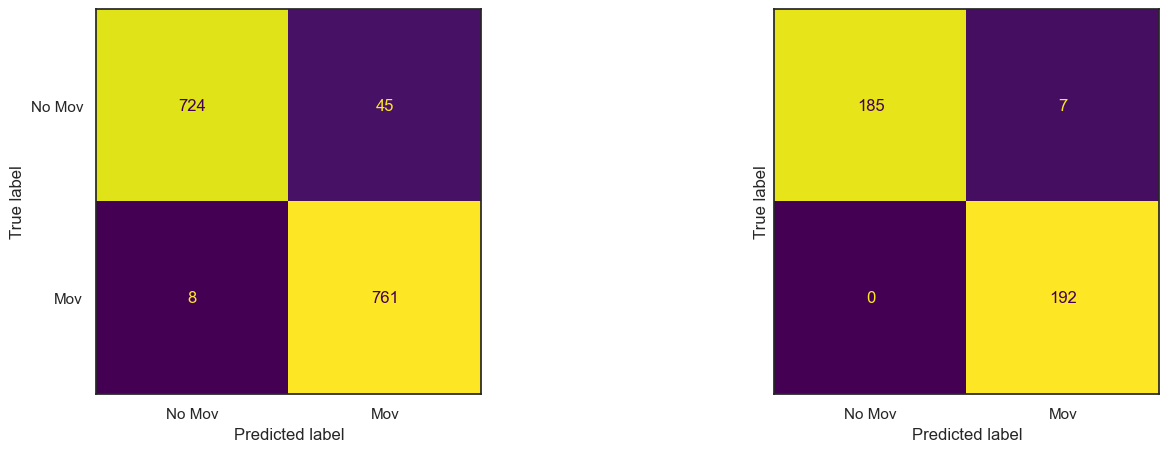

In [60]:
matrix1(finalmodel,TrainOne, TrainOneL,TestOne,TestOneL)

In [61]:
Encode = Model(inputs=visible, outputs=encoder)

In [62]:
M=Encode.predict(TrainOne)
N=TrainOneL
O=Encode.predict(TestOne)
P=TestOneL

12/12 [==============================] - 0s 25ms/step


In [63]:
M=M.reshape((M.shape[0],M.shape[1],1))
O=O.reshape((O.shape[0],O.shape[1],1))
M.shape

(1538, 100, 1)

[0 1]
CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.01 µs


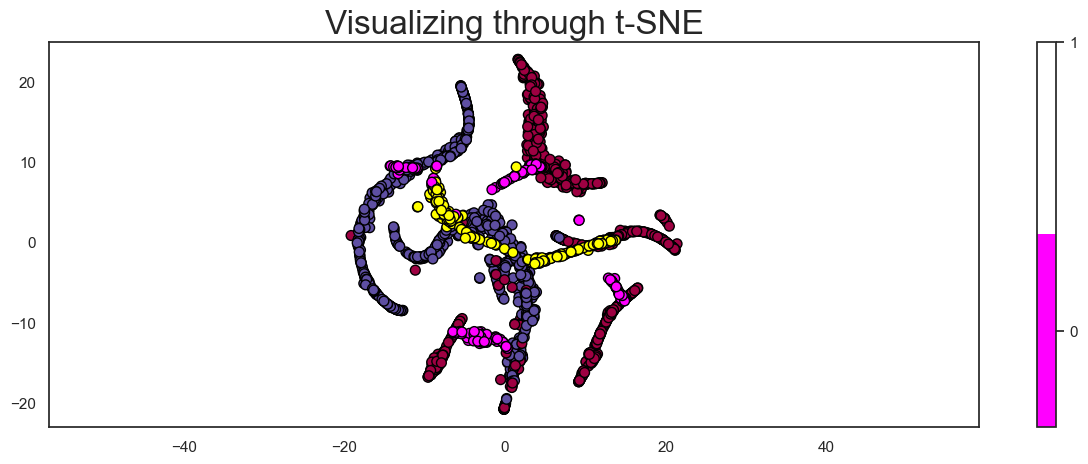

In [64]:
tSNE(M, N, O, P)